# ViT

## First approach: Fine Tuning

We will fine-tune the google pre-trained ViT to adjust weights of the model to our task.

Here is a reminder of the ViT architecture

Voir Dino V2

![ViT](images/ViT.png)


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

from tqdm import tqdm
from pathlib import Path
from torchvision.transforms import v2
from torch.utils.data import DataLoader

from methods import BasicCNN
from utils import WildfireDataset
from utils import split_val_dataset

In [2]:
device = torch.device('mps') # MacOS
# variables #
batchsize = 10
data_folder = Path("./data/valid")

In [3]:
# Data loading
train, test = split_val_dataset(data_folder)

transform = v2.Compose([
    v2.ToImage(), # Convert into Image tensor
    v2.ToDtype(torch.float32, scale=True)
])

train_dataset = WildfireDataset(train, transform)
test_dataset = WildfireDataset(test, transform)

trainloader: DataLoader = train_dataset.__dataloader__(batchsize, num_workers=4)
testloader: DataLoader = test_dataset.__dataloader__(batchsize, num_workers=4)

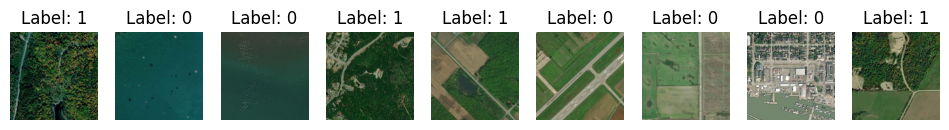

In [4]:
list_to_show = range(1, 10)
train_dataset.__showitems__(list_to_show)

## Data preprocessing

In [5]:
num_classes = 2
epochs = 50
batch_size = 10
learning_rate = 1e-2

In [6]:
# Model to use: try dino v2
from transformers import ViTFeatureExtractor, ViTForImageClassification, TrainingArguments, Trainer
model_name = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name) # used to ensure that params used for fine tuning are the same used during pre training


/Users/taoguinot/.pyenv/versions/3.12.0/lib/python3.12/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [7]:
# ViT are pre-trained on images of specific size (224x224 for google vit model)
from torchvision.transforms import v2
transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),  # Scale pixel values to [0, 1]
    v2.Resize((224, 224)),  # Resize images to 224x224
    v2.Normalize(
        mean=torch.tensor(feature_extractor.image_mean, dtype=torch.float32).tolist(),
        std=torch.tensor(feature_extractor.image_std, dtype=torch.float32).tolist()
    ),  # Normalize with float32
])

# Apply the updated transform to your dataset
train_dataset = WildfireDataset(train, transform=transform)
test_dataset = WildfireDataset(test, transform=transform)

In [8]:
trainloader: DataLoader = train_dataset.__dataloader__(batchsize=16, num_workers=4)
testloader: DataLoader = test_dataset.__dataloader__(batchsize=16, num_workers=4)

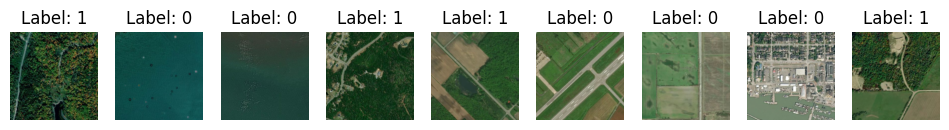

In [9]:
train_dataset.__showitems__(list_to_show, mean=feature_extractor.image_mean, std=feature_extractor.image_std)

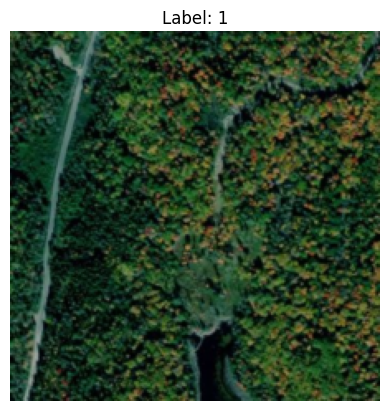

In [10]:
train_dataset.__showitem__(1, mean=feature_extractor.image_mean, std=feature_extractor.image_std)

### Data collator

Takes in a batch of data (list of dict each containing pixel_values and labels as keys, return dict containing 2 tensors pixel_values and labels)

In [11]:
# Define the data collator
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['label'] for x in batch])
    }

## Trining setup

In [12]:
model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels = num_classes,
    id2label = {0:'Normal', 1:'Fire'},
    label2id = {'Normal':0, 'Fire':1})

device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.mps.is_available() else 'cpu')
model.to(device)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [13]:
# default uses adamW optimizer
training_args = TrainingArguments(
  use_mps_device=True,
  output_dir="./vit-fire-detection",
  per_device_train_batch_size=batch_size,
  per_device_eval_batch_size=batch_size,
  evaluation_strategy="epoch",
  save_strategy="epoch",
  logging_steps=50,
  num_train_epochs=epochs,

  learning_rate=learning_rate,
  weight_decay=0.01,
  adam_beta1=0.9,
  adam_beta2=0.999,
  adam_epsilon=1e-8,
  warmup_steps=100,

  save_total_limit=1,
  remove_unused_columns=False,
  push_to_hub=False, #set to "end" and call save_model()
  report_to=None,
  load_best_model_at_end=True
)

/Users/taoguinot/.pyenv/versions/3.12.0/lib/python3.12/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/Users/taoguinot/.pyenv/versions/3.12.0/lib/python3.12/site-packages/transformers/training_args.py:2255: UserWarning: `use_mps_device` is deprecated and will be removed in version 5.0 of 🤗 Transformers. `mps` device will be used by default if available similar to the way `cuda` device is used.Therefore, no action from user is required. 
  warnings.warn(


In [14]:
def compute_metrics(pred):
    from sklearn.metrics import accuracy_score
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}

In [15]:
## Compute the trainer: collate_fn is the data collator, compute_metrics for evaluation

from datasets import DatasetDict

train_dataset_hf = DatasetDict({
    "train": train_dataset,
    "test": test_dataset,
})

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset_hf["train"],
    eval_dataset=train_dataset_hf["test"],
    tokenizer=feature_extractor
)

/var/folders/h1/czlwlk_50vq1xdyv651xbn280000gn/T/ipykernel_5480/162778920.py:10: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [16]:
for batch in train_dataset.__dataloader__(batchsize=4):
    print(batch["pixel_values"].dtype, batch["labels"].dtype)


torch.float32 torch.int64
torch.float32 torch.int64
torch.float32 torch.int64
torch.float32 torch.int64
torch.float32 torch.int64
torch.float32 torch.int64
torch.float32 torch.int64
torch.float32 torch.int64
torch.float32 torch.int64
torch.float32 torch.int64
torch.float32 torch.int64
torch.float32 torch.int64
torch.float32 torch.int64
torch.float32 torch.int64
torch.float32 torch.int64
torch.float32 torch.int64
torch.float32 torch.int64
torch.float32 torch.int64
torch.float32 torch.int64
torch.float32 torch.int64
torch.float32 torch.int64
torch.float32 torch.int64
torch.float32 torch.int64
torch.float32 torch.int64
torch.float32 torch.int64
torch.float32 torch.int64
torch.float32 torch.int64
torch.float32 torch.int64
torch.float32 torch.int64
torch.float32 torch.int64
torch.float32 torch.int64
torch.float32 torch.int64
torch.float32 torch.int64
torch.float32 torch.int64
torch.float32 torch.int64
torch.float32 torch.int64
torch.float32 torch.int64
torch.float32 torch.int64
torch.float3

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x10c2ff6a0>
Traceback (most recent call last):
  File "/Users/taoguinot/.pyenv/versions/3.12.0/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/Users/taoguinot/.pyenv/versions/3.12.0/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1582, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/Users/taoguinot/.pyenv/versions/3.12.0/lib/python3.12/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/taoguinot/.pyenv/versions/3.12.0/lib/python3.12/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/taoguinot/.pyenv/versions/3.12.0/lib/python3.12/multiprocessing/connection.py", line 1118, in wait
    ready = selector.select(ti

KeyboardInterrupt: 

In [17]:
trainer.train()

  0%|          | 0/25200 [00:00<?, ?it/s]

{'loss': 0.4475, 'grad_norm': 0.2923714518547058, 'learning_rate': 0.005, 'epoch': 0.1}
{'loss': 0.4712, 'grad_norm': 0.19347438216209412, 'learning_rate': 0.01, 'epoch': 0.2}
{'loss': 0.4593, 'grad_norm': 0.7514984011650085, 'learning_rate': 0.0099800796812749, 'epoch': 0.3}
{'loss': 0.5861, 'grad_norm': 1.272289752960205, 'learning_rate': 0.0099601593625498, 'epoch': 0.4}
{'loss': 0.4984, 'grad_norm': 0.9481183886528015, 'learning_rate': 0.0099402390438247, 'epoch': 0.5}
{'loss': 0.4783, 'grad_norm': 0.7896044254302979, 'learning_rate': 0.009920318725099601, 'epoch': 0.6}
{'loss': 0.3943, 'grad_norm': 0.6748299598693848, 'learning_rate': 0.009900398406374503, 'epoch': 0.69}
{'loss': 0.45, 'grad_norm': 0.7175833582878113, 'learning_rate': 0.009880478087649403, 'epoch': 0.79}
{'loss': 0.4411, 'grad_norm': 0.3496270775794983, 'learning_rate': 0.009860557768924303, 'epoch': 0.89}
{'loss': 0.4766, 'grad_norm': 0.5987311005592346, 'learning_rate': 0.009840637450199204, 'epoch': 0.99}


  0%|          | 0/126 [00:00<?, ?it/s]

{'eval_loss': 0.47185030579566956, 'eval_accuracy': 0.8095238095238095, 'eval_runtime': 23.5262, 'eval_samples_per_second': 53.557, 'eval_steps_per_second': 5.356, 'epoch': 1.0}
{'loss': 0.5179, 'grad_norm': 0.5779136419296265, 'learning_rate': 0.009820717131474104, 'epoch': 1.09}
{'loss': 0.424, 'grad_norm': 0.6629857420921326, 'learning_rate': 0.009800796812749004, 'epoch': 1.19}
{'loss': 0.4537, 'grad_norm': 1.0579513311386108, 'learning_rate': 0.009780876494023904, 'epoch': 1.29}
{'loss': 0.4119, 'grad_norm': 0.2888517677783966, 'learning_rate': 0.009760956175298804, 'epoch': 1.39}
{'loss': 0.4111, 'grad_norm': 1.3037333488464355, 'learning_rate': 0.009741035856573706, 'epoch': 1.49}
{'loss': 0.3993, 'grad_norm': 0.6904603242874146, 'learning_rate': 0.009721115537848607, 'epoch': 1.59}
{'loss': 0.4087, 'grad_norm': 0.561478853225708, 'learning_rate': 0.009701195219123507, 'epoch': 1.69}
{'loss': 0.3929, 'grad_norm': 0.3943929970264435, 'learning_rate': 0.009681274900398407, 'epoch'

  0%|          | 0/126 [00:00<?, ?it/s]

{'eval_loss': 0.35907918214797974, 'eval_accuracy': 0.8579365079365079, 'eval_runtime': 23.3937, 'eval_samples_per_second': 53.861, 'eval_steps_per_second': 5.386, 'epoch': 2.0}
{'loss': 0.3769, 'grad_norm': 2.006683826446533, 'learning_rate': 0.009621513944223108, 'epoch': 2.08}
{'loss': 0.3532, 'grad_norm': 0.8049749135971069, 'learning_rate': 0.009601593625498008, 'epoch': 2.18}
{'loss': 0.3712, 'grad_norm': 0.16466790437698364, 'learning_rate': 0.00958167330677291, 'epoch': 2.28}
{'loss': 0.3589, 'grad_norm': 0.7513273358345032, 'learning_rate': 0.00956175298804781, 'epoch': 2.38}
{'loss': 0.3897, 'grad_norm': 0.4643026292324066, 'learning_rate': 0.00954183266932271, 'epoch': 2.48}
{'loss': 0.4002, 'grad_norm': 0.24603231251239777, 'learning_rate': 0.00952191235059761, 'epoch': 2.58}
{'loss': 0.3455, 'grad_norm': 0.5678448677062988, 'learning_rate': 0.00950199203187251, 'epoch': 2.68}
{'loss': 0.3516, 'grad_norm': 0.10254032164812088, 'learning_rate': 0.00948207171314741, 'epoch': 

  0%|          | 0/126 [00:00<?, ?it/s]

{'eval_loss': 0.3652728796005249, 'eval_accuracy': 0.8626984126984127, 'eval_runtime': 23.3737, 'eval_samples_per_second': 53.907, 'eval_steps_per_second': 5.391, 'epoch': 3.0}
{'loss': 0.392, 'grad_norm': 0.6730523705482483, 'learning_rate': 0.009422310756972111, 'epoch': 3.08}
{'loss': 0.3453, 'grad_norm': 1.1052658557891846, 'learning_rate': 0.009402390438247013, 'epoch': 3.17}
{'loss': 0.3898, 'grad_norm': 0.255037784576416, 'learning_rate': 0.009382470119521914, 'epoch': 3.27}
{'loss': 0.4411, 'grad_norm': 0.21497385203838348, 'learning_rate': 0.009362549800796812, 'epoch': 3.37}
{'loss': 0.3851, 'grad_norm': 0.25893735885620117, 'learning_rate': 0.009342629482071712, 'epoch': 3.47}
{'loss': 0.4988, 'grad_norm': 0.1763269603252411, 'learning_rate': 0.009322709163346612, 'epoch': 3.57}
{'loss': 0.3855, 'grad_norm': 0.3276210129261017, 'learning_rate': 0.009302788844621514, 'epoch': 3.67}
{'loss': 0.3767, 'grad_norm': 0.5444031357765198, 'learning_rate': 0.009282868525896415, 'epoch

  0%|          | 0/126 [00:00<?, ?it/s]

{'eval_loss': 0.3991242051124573, 'eval_accuracy': 0.8293650793650794, 'eval_runtime': 23.4557, 'eval_samples_per_second': 53.718, 'eval_steps_per_second': 5.372, 'epoch': 4.0}
{'loss': 0.3754, 'grad_norm': 68.85974884033203, 'learning_rate': 0.009223107569721115, 'epoch': 4.07}
{'loss': 0.4008, 'grad_norm': 0.7479811906814575, 'learning_rate': 0.009203187250996015, 'epoch': 4.17}
{'loss': 0.4075, 'grad_norm': 0.6768124103546143, 'learning_rate': 0.009183266932270916, 'epoch': 4.27}
{'loss': 0.3731, 'grad_norm': 2.5319507122039795, 'learning_rate': 0.009163346613545816, 'epoch': 4.37}
{'loss': 0.3551, 'grad_norm': 0.28237012028694153, 'learning_rate': 0.009143426294820718, 'epoch': 4.46}
{'loss': 0.3463, 'grad_norm': 0.2726319432258606, 'learning_rate': 0.009123505976095618, 'epoch': 4.56}
{'loss': 0.3706, 'grad_norm': 0.5032656192779541, 'learning_rate': 0.009103585657370518, 'epoch': 4.66}
{'loss': 0.3692, 'grad_norm': 0.3273816406726837, 'learning_rate': 0.009083665338645418, 'epoch

  0%|          | 0/126 [00:00<?, ?it/s]

{'eval_loss': 0.37766143679618835, 'eval_accuracy': 0.8444444444444444, 'eval_runtime': 215.9337, 'eval_samples_per_second': 5.835, 'eval_steps_per_second': 0.584, 'epoch': 5.0}
{'loss': 0.3585, 'grad_norm': 0.4234113395214081, 'learning_rate': 0.009023904382470119, 'epoch': 5.06}
{'loss': 0.3728, 'grad_norm': 1.5369349718093872, 'learning_rate': 0.00900398406374502, 'epoch': 5.16}
{'loss': 0.3801, 'grad_norm': 0.24062436819076538, 'learning_rate': 0.00898406374501992, 'epoch': 5.26}
{'loss': 0.393, 'grad_norm': 0.2877640426158905, 'learning_rate': 0.008964143426294821, 'epoch': 5.36}
{'loss': 0.3589, 'grad_norm': 0.4661458432674408, 'learning_rate': 0.008944223107569722, 'epoch': 5.46}
{'loss': 0.3603, 'grad_norm': 0.5675711631774902, 'learning_rate': 0.008924302788844622, 'epoch': 5.56}
{'loss': 0.3512, 'grad_norm': 0.29752057790756226, 'learning_rate': 0.008904382470119522, 'epoch': 5.65}
{'loss': 0.3486, 'grad_norm': 0.40610194206237793, 'learning_rate': 0.008884462151394422, 'epoc

  0%|          | 0/126 [00:00<?, ?it/s]

{'eval_loss': 0.3680999279022217, 'eval_accuracy': 0.8555555555555555, 'eval_runtime': 22.4288, 'eval_samples_per_second': 56.178, 'eval_steps_per_second': 5.618, 'epoch': 6.0}
{'loss': 0.3473, 'grad_norm': 0.9390835165977478, 'learning_rate': 0.008824701195219123, 'epoch': 6.05}
{'loss': 0.3064, 'grad_norm': 0.28521737456321716, 'learning_rate': 0.008804780876494025, 'epoch': 6.15}
{'loss': 0.3613, 'grad_norm': 0.35563626885414124, 'learning_rate': 0.008784860557768925, 'epoch': 6.25}
{'loss': 0.3319, 'grad_norm': 0.3101964592933655, 'learning_rate': 0.008764940239043825, 'epoch': 6.35}
{'loss': 0.327, 'grad_norm': 0.25121209025382996, 'learning_rate': 0.008745019920318725, 'epoch': 6.45}
{'loss': 0.3844, 'grad_norm': 0.43918195366859436, 'learning_rate': 0.008725099601593626, 'epoch': 6.55}
{'loss': 0.3843, 'grad_norm': 0.17289786040782928, 'learning_rate': 0.008705179282868526, 'epoch': 6.65}
{'loss': 0.3976, 'grad_norm': 2.2827985286712646, 'learning_rate': 0.008685258964143426, 'e

  0%|          | 0/126 [00:00<?, ?it/s]

{'eval_loss': 0.3259947896003723, 'eval_accuracy': 0.8658730158730159, 'eval_runtime': 986.9322, 'eval_samples_per_second': 1.277, 'eval_steps_per_second': 0.128, 'epoch': 7.0}
{'loss': 0.3474, 'grad_norm': 0.24002505838871002, 'learning_rate': 0.008625498007968128, 'epoch': 7.04}
{'loss': 0.3429, 'grad_norm': 0.46316102147102356, 'learning_rate': 0.008605577689243029, 'epoch': 7.14}
{'loss': 0.3423, 'grad_norm': 1.1208280324935913, 'learning_rate': 0.008585657370517929, 'epoch': 7.24}
{'loss': 0.3034, 'grad_norm': 0.2085462361574173, 'learning_rate': 0.008565737051792829, 'epoch': 7.34}
{'loss': 0.3121, 'grad_norm': 0.5865440368652344, 'learning_rate': 0.00854581673306773, 'epoch': 7.44}
{'loss': 0.3588, 'grad_norm': 0.5920065641403198, 'learning_rate': 0.00852589641434263, 'epoch': 7.54}
{'loss': 0.393, 'grad_norm': 0.3263796865940094, 'learning_rate': 0.00850597609561753, 'epoch': 7.64}
{'loss': 0.3509, 'grad_norm': 0.6148982048034668, 'learning_rate': 0.00848605577689243, 'epoch': 

  0%|          | 0/126 [00:00<?, ?it/s]

{'eval_loss': 0.3478202223777771, 'eval_accuracy': 0.8515873015873016, 'eval_runtime': 1017.1042, 'eval_samples_per_second': 1.239, 'eval_steps_per_second': 0.124, 'epoch': 8.0}
{'loss': 0.3557, 'grad_norm': 0.9658048152923584, 'learning_rate': 0.008426294820717132, 'epoch': 8.04}
{'loss': 0.3544, 'grad_norm': 0.946232795715332, 'learning_rate': 0.008406374501992032, 'epoch': 8.13}
{'loss': 0.3555, 'grad_norm': 0.8882908821105957, 'learning_rate': 0.008386454183266933, 'epoch': 8.23}
{'loss': 0.3605, 'grad_norm': 0.39518803358078003, 'learning_rate': 0.008366533864541833, 'epoch': 8.33}
{'loss': 0.3216, 'grad_norm': 0.4585210382938385, 'learning_rate': 0.008346613545816733, 'epoch': 8.43}
{'loss': 0.3692, 'grad_norm': 0.4563945233821869, 'learning_rate': 0.008326693227091633, 'epoch': 8.53}
{'loss': 0.3566, 'grad_norm': 0.11213646084070206, 'learning_rate': 0.008306772908366535, 'epoch': 8.63}
{'loss': 0.3526, 'grad_norm': 0.7377097606658936, 'learning_rate': 0.008286852589641435, 'epo

  0%|          | 0/126 [00:00<?, ?it/s]

{'eval_loss': 0.3000245690345764, 'eval_accuracy': 0.8849206349206349, 'eval_runtime': 519.8788, 'eval_samples_per_second': 2.424, 'eval_steps_per_second': 0.242, 'epoch': 9.0}
{'loss': 0.3026, 'grad_norm': 0.3003618121147156, 'learning_rate': 0.008227091633466136, 'epoch': 9.03}
{'loss': 0.3921, 'grad_norm': 1.2788268327713013, 'learning_rate': 0.008207171314741036, 'epoch': 9.13}
{'loss': 0.2548, 'grad_norm': 0.2237568348646164, 'learning_rate': 0.008187250996015936, 'epoch': 9.23}
{'loss': 0.3813, 'grad_norm': 0.34672680497169495, 'learning_rate': 0.008167330677290837, 'epoch': 9.33}
{'loss': 0.3464, 'grad_norm': 1.2478516101837158, 'learning_rate': 0.008147410358565737, 'epoch': 9.42}
{'loss': 0.3926, 'grad_norm': 0.390551894903183, 'learning_rate': 0.008127490039840639, 'epoch': 9.52}
{'loss': 0.3327, 'grad_norm': 0.2940759062767029, 'learning_rate': 0.008107569721115537, 'epoch': 9.62}
{'loss': 0.3198, 'grad_norm': 0.37823593616485596, 'learning_rate': 0.008087649402390438, 'epoc

KeyboardInterrupt: 

## Inference

In [18]:
from PIL import Image
from transformers import ViTFeatureExtractor

feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")

# Load an image and preprocess
image = Image.open("path/to/image.jpg").convert("RGB")
inputs = feature_extractor(images=image, return_tensors="pt")

# Get predictions
outputs = model(**inputs)
predicted_class = outputs.logits.argmax(-1).item()
label = model.config.id2label[predicted_class]

print(f"Predicted class: {label}")


/Users/taoguinot/.pyenv/versions/3.12.0/lib/python3.12/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


FileNotFoundError: [Errno 2] No such file or directory: '/Users/taoguinot/Documents/ENSTA/3A/Computer Vision/Projet Finl/Wildfire-Prediction-VisionML/path/to/image.jpg'